In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.metrics import f1_score, roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, roc_curve

import imblearn

from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [2]:
def oversampling(x_mi,x_ma,ratio,categorical_columns):
    
    num_dim = np.shape(x_ma)[1]
    
   
    dataset_majority = np.c_[x_ma, np.zeros(np.shape(x_ma)[0])]
    dataset_minority = np.c_[x_mi, np.ones(np.shape(x_mi)[0])]
    
    dataset = np.concatenate((dataset_majority, dataset_minority))

    X = dataset[:,0:num_dim]
    
    y = dataset[:,num_dim]
    y=y.astype('int')
    
    over = SMOTENC(sampling_strategy=ratio, categorical_features=categorical_columns)
    #over = SMOTE(sampling_strategy=ratio)
    steps = [('o', over)]
    pipeline = Pipeline(steps=steps)
    # transform the dataset
    X_over, y_over = pipeline.fit_resample(X, y)

    X_over_majority = X_over[y_over < 1]
    y_over_majority = y_over[y_over < 1]

    X_over_minority = X_over[y_over > 0]
    y_over_minority = y_over[y_over > 0]
    
    return X_over_minority

In [3]:
data = pd.read_pickle("./data.pkl")
## Remove columns of languages
# data = data.iloc[:,0:12]

In [4]:

categorical_columns = [data.columns.get_loc(c) for c in data.select_dtypes(exclude=["number"]).columns if c in data]

# split data into X and y
X = data.loc[:, data.columns != 'bot']
Y = data.loc[:, data.columns == 'bot'].to_numpy()

# split data into train and test sets
seed = 10
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [5]:
# Oversampling of training set

X_train_majority = X_train[y_train < 1] # human (non-bots) are majority
X_train_minority = X_train[y_train > 0]


In [6]:
X_over_train_minority = oversampling(X_train_majority, X_train_minority, 0.6, categorical_columns)

dataset_train_majority = np.c_[X_train_majority, -1*np.ones(np.shape(X_train_majority)[0])]
dataset_train_minority = np.c_[X_over_train_minority, np.ones(np.shape(X_over_train_minority)[0])]

dataset_train = np.concatenate((dataset_train_majority, dataset_train_minority))

X_train = dataset_train[:,0:np.shape(X)[1]]
y_train = dataset_train[:,np.shape(X)[1]].astype('int')

In [7]:
X_train

array([[False, False, 2364, ..., 0, 0, 0],
       [True, False, 95, ..., 0, 0, 0],
       [True, False, 44447, ..., 0, 0, 0],
       ...,
       [True, False, 35234.0, ..., 0.0, 0.0, 0.0],
       [False, False, 8963.0, ..., 0.0, 0.0, 0.0],
       [False, False, 28.0, ..., 0.0, 0.0, 0.0]], dtype=object)

In [8]:
# Labels for this algortihm has to be either 1 or -1
# y_train = np.where(y_train < 0.5, -1, 1)
y_test = np.where(y_test < 0.5, -1, 1)

y_train = y_train.flatten()
y_test = y_test.flatten()

In [9]:
number_iterations = 100

number_samples = np.shape(X_train)[0]

weights = np.ones(number_samples)/number_samples

# There will be as many weak learners as iterations
weak_learners = np.zeros(shape=number_iterations, dtype=object)

significance_vec = np.zeros(shape=number_iterations)

error_vec = []
accuracy_vec = []

for iterations in range(number_iterations):
    
    current_weights = weights
    
    weak_learner = DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2)
    weak_learner_model = weak_learner.fit(X_train, y_train, sample_weight=current_weights)
    
    
    # The new weak learner model is saved
    weak_learners[iterations] = weak_learner_model
    
    weak_learner_pred = weak_learner_model.predict(X_train)
    
    error = 0
    incorrect_pred = 0
    correct_pred = 0
    
    for item_index in range(number_samples):

        if weak_learner_pred[item_index] != y_train[item_index]:
            incorrect_pred = incorrect_pred + 1
            error = error + current_weights[item_index]
        else: 
            correct_pred = correct_pred + 1 
            
    # Save error for plotting    
    error_vec.append(error)
    
    # Significance of the weak learner model is calculated and saved
   
    significance = 0.5*np.log((1-error)/error) 
        
    significance_vec[iterations] = significance

    #########################
    
    # Update weights for each sample
    
    for item_index in range(number_samples):
        if weak_learner_pred[item_index] != y_train[item_index]:

            weights[item_index] = np.multiply(current_weights[item_index],np.exp(significance))

        else:
            weights[item_index] = current_weights[item_index]*np.exp(-significance)
     
    # Alternative
    # weights = current_weights * np.exp(-significance*  y_train * weak_learner_pred)
    

    #########################
    
    # Normalize weights
    
    weights /= weights.sum()
   
    

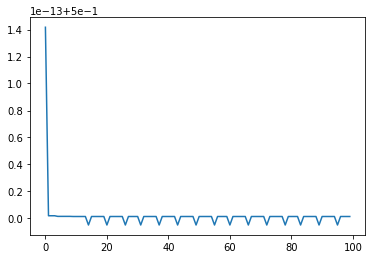

In [10]:
plt.plot(error_vec)
plt.show()

In [11]:
# Get prediction of each weak learner 
model_preds = np.array([model.predict(X_test) for model in weak_learners])
y_test_pred = np.sign(np.dot(significance_vec, model_preds))

In [12]:
# Calculate accuracy 

for item_index in range(np.shape(y_test_pred)[0]):

        if y_test_pred[item_index] == y_test[item_index]:

            correct_pred = correct_pred + 1 
            
print("Accuracy = " + str(correct_pred/number_samples))

Accuracy = 0.5897320188836435


In [13]:
f1_score = f1_score(y_test, y_test_pred, average='weighted')
print("F1 Score Adaboost: " + str(f1_score))

F1 Score Adaboost: 0.11155363793930005
